In [2]:
RUNNING_LOCALLY = True

In [3]:
import os

# PLEASE SET YOUR OWN WORKING_DIRECTORY WHEN RUNNING LOCALLY
WORKING_DIRECTORY = "/home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/"

if not RUNNING_LOCALLY:
    os.chdir("/home/yash/")
    print("Current Directory ->", os.getcwd())

    WORKING_DIRECTORY = "/home/yash/working_dir/"

    # Ensure that you are working in the right environment
    !echo $CONDA_PREFIX

In [5]:
import gym
import time
import numpy as np
from collections import deque
from gym import spaces
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
class ConcatObs(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = \
            spaces.Box(low=0, high=255, shape=((k,) + shp), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        return np.array(self.frames)

In [124]:
# A bunch of wrappers to get us started, please use these
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, GRAYSCALE=False, NORMALIZE=False):
        self.GRAYSCALE = GRAYSCALE
        self.NORMALIZE = NORMALIZE
        super().__init__(env)
    
    def observation(self, obs):
        # Normalise observation by 255

        
        if self.NORMALIZE:
            obs = obs / 255.0
        # Convert to grayscale -> This isn't quite working right now, but we can update the function quite easily later
        if self.GRAYSCALE:
#             obs = obs
            obs = tf.image.rgb_to_grayscale(obs)
                    
        image = obs[:,2:-9,8:,:]
        image = tf.image.resize(image,[84,84])
        image = tf.transpose(tf.reshape(image, image.shape[:-1]),perm = [1,2,0])
        return image

class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, reward):
        # Clip reward between 0 to 1
        return np.clip(reward, 0, 1)
    
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, action):
        return action

In [125]:
env = gym.make("ALE/Riverraid-v5")

In [126]:
# Using the wrappers for the environment
env = ObservationWrapper(RewardWrapper(ActionWrapper(ConcatObs(env, 4))), GRAYSCALE=True, NORMALIZE=True)
obs = env.reset()

In [116]:
#visualization
#image = tf.keras.preprocessing.image.array_to_img(tf.reshape(image[:,:,3],[84,84,1]))

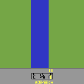

In [88]:
image1 = tf.image.resize(obs_,[84,84])
tf.keras.preprocessing.image.array_to_img(image1)

**DQN**

In [138]:
hidden_size = 256
num_actions = 18
# q_net = tf.keras.Sequential()
# q_net.add(tf.keras.layers.Flatten())
# q_net.add(tf.keras.layers.Dense(hidden_size, activation='relu'))
# q_net.add(tf.keras.layers.Dense(num_actions, activation='softmax'))
#we can try to add convolutional layers

def create_q_model(input_shape, hidden_size, num_actions):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=input_shape)
    # Convolutions on the frames on the screen
    
    layer1 = layers.Conv2D(16, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(32, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Flatten()(layer2)
    layer4 = tf.keras.layers.Dense(hidden_size, activation='relu')(layer3) 
    action = tf.keras.layers.Dense(num_actions, activation='softmax')(layer4)

    return keras.Model(inputs=inputs, outputs=action)

q_net = create_q_model(input_shape=obs.shape, hidden_size=hidden_size, num_actions=num_actions)

In [155]:
trainer = tf.keras.optimizers.SGD(learning_rate = 0.01)

**One episode**

In [144]:
#hyper parameters
num_steps = 500
obs = env.reset()
rTot = 0
gamma = 0.99
e = 0.2

start_time = time.time()
for step in range(num_steps):

    
    with tf.GradientTape() as tape:
        # Compute the Q values and best action for the current state
        q_values = q_net(np.array([obs]))
        action = tf.math.argmax(q_values,axis=1).numpy()[0]
        
        # Epsilon adaptive
        if np.random.rand(1) < e:
            action = env.action_space.sample()

        # apply the action
        nst_obs, reward, done, _ = env.step(action)
        
        
        q_values_nst = q_net(np.array([nst_obs]))
        action_nst = tf.math.argmax(q_values_nst,axis=1).numpy()[0]
        
        td_error = q_values.numpy()
        td_error[0][action] = reward + gamma*np.max(q_values_nst)
        loss = tf.reduce_sum(tf.square(td_error-q_values))
        
    grad = tape.gradient(loss,q_net.trainable_variables)
    trainer.apply_gradients(zip(grad,q_net.trainable_variables))
    rTot += reward
    
    obs = nst_obs
    
    if done:
        break
    
end_time = time.time()
inter = end_time-start_time

# Close the env
env.close()

**Episodes with n_game**

In [157]:
num_steps = 500
obs = env.reset()
rTot = 0
gamma = 0.99
n_games = 1000 #when running in the GCP, we can set a much higher value
E = 1000

rot_list = []
time_list = []
for i in range(0, n_games):
    if (i+1)%25 == 0:
        print(f'Running game {i+1}/{n_games}...')
    
    e = E / (i + E)
    if e < 0.1:
        e = 0.1
        
    obs = env.reset()
    start_time = time.time()
    for step in range(num_steps):

        with tf.GradientTape() as tape:
            # Compute the Q values and best action for the current state
            q_values = q_net(np.array([obs]))

            # Epsilon adaptive
            if np.random.rand(1) < e:
                action = env.action_space.sample()
            else:
                # Added an else statement so the command only runs if necessary
                action = tf.math.argmax(q_values,axis=1).numpy()[0]

            # apply the action
            nst_obs, reward, done, _ = env.step(action)


            q_values_nst = q_net(np.array([nst_obs]))
            action_nst = tf.math.argmax(q_values_nst,axis=1).numpy()[0]

            td_error = q_values.numpy()
            td_error[0][action] = reward + gamma*np.max(q_values_nst)
            loss = tf.reduce_sum(tf.square(td_error-q_values))

        grad = tape.gradient(loss,q_net.trainable_variables)
        trainer.apply_gradients(zip(grad,q_net.trainable_variables))
        rTot += reward

        obs = nst_obs

        if done:
            break

    end_time = time.time()
    inter = end_time-start_time
    rot_list.append(rTot)
    time_list.append(inter)

env.close()

Running game 1/100...
Running game 2/100...
Running game 3/100...
Running game 4/100...
Running game 5/100...
Running game 6/100...
Running game 7/100...
Running game 8/100...
Running game 9/100...
Running game 10/100...
Running game 11/100...
Running game 12/100...
Running game 13/100...
Running game 14/100...
Running game 15/100...
Running game 16/100...
Running game 17/100...
Running game 18/100...
Running game 19/100...
Running game 20/100...
Running game 21/100...
Running game 22/100...
Running game 23/100...
Running game 24/100...
Running game 25/100...
Running game 26/100...
Running game 27/100...
Running game 28/100...
Running game 29/100...
Running game 30/100...
Running game 31/100...
Running game 32/100...
Running game 33/100...
Running game 34/100...
Running game 35/100...
Running game 36/100...
Running game 37/100...
Running game 38/100...
Running game 39/100...
Running game 40/100...
Running game 41/100...
Running game 42/100...
Running game 43/100...
Running game 44/100.

In [ ]:
print("average_reward:{}".format(sum(rot_list)/n_games))
print("average_time:{}".format(sum(time_list)/n_games))

1. After 100 games:<br>
   average_reward:773.95<br>
   average_time:21.668797335624696<br>

In [162]:
sum(rot_list[-5:])/5

1534.6

In [163]:
sum(time_list[-5:])/5

15.960728788375855

In [172]:
model_path = "model/cDQN_" + str(n_games)
q_net.save(model_path)

INFO:tensorflow:Assets written to: model/cDQN_100\assets


In [173]:
q_net_copy = keras.models.load_model(model_path)

In [1]:
# q_net_copy.get_weights()